## Setup

In [ ]:
# basic import
import numpy as np
import pandas as pd
import sys
import os

# tensorflow/keras
import tensorflow as tf
from tensorflow.python.client import device_lib
import keras
from keras import layers, models, regularizers, layers
from keras.callbacks import TensorBoard, ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.optimizers import Adamax, RMSprop, SGD
from keras.preprocessing.image import ImageDataGenerator

# sklearn
import sklearn
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, classification_report, auc
from sklearn.metrics import accuracy_score, RocCurveDisplay
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import LabelBinarizer

# visualizations
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
import seaborn as sb
%matplotlib inline

In [ ]:
train_dir = './xPLNet(1)/DATASET/Training Samples'
test_dir  = './xPLNet(1)/DATASET/Test Samples'

## Data Augmentation

In [ ]:
# w/augmentations
data_generator1 = ImageDataGenerator(featurewise_center=False,
                                     samplewise_center=False,
                                     featurewise_std_normalization=False,
                                     samplewise_std_normalization=False,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     horizontal_flip=True,
                                     vertical_flip=False,
                                     rotation_range=15,
                                     rescale=1./255,
                                     validation_split=0.2)
# clean generator
data_generator2 = ImageDataGenerator(featurewise_center=False,
                                     samplewise_center=False,
                                     featurewise_std_normalization=False,
                                     samplewise_std_normalization=False,
                                     width_shift_range=0,
                                     height_shift_range=0,
                                     horizontal_flip=False,
                                     vertical_flip=False,
                                     rotation_range=0,
                                     rescale=1./255)

train_dataset = data_generator1.flow_from_directory(train_dir,
                                                   target_size=(224, 224),
                                                   class_mode='categorical',
                                                   batch_size=8,
                                                   shuffle=False,
                                                   subset='training')

val_dataset = data_generator1.flow_from_directory(train_dir,
                                                 target_size=(224, 224),
                                                 class_mode='categorical',
                                                 batch_size=8,
                                                 shuffle=False,
                                                 subset='validation')

test_dataset = data_generator2.flow_from_directory(test_dir,
                                                   target_size=(224, 224),
                                                   class_mode='categorical',
                                                   batch_size=8,
                                                   shuffle=False)

Found 47351 images belonging to 9 classes.
Found 11833 images belonging to 9 classes.
Found 5993 images belonging to 9 classes.


In [ ]:
print(f'Training Dataset: {len(train_dataset)*8} Images')
print(f'Validation Dataset: {len(val_dataset)*8} Images')
print(f'Testing Dataset: {len(test_dataset)*8} Images')

Training Dataset: 47352 Images
Validation Dataset: 11840 Images
Testing Dataset: 5120 Images


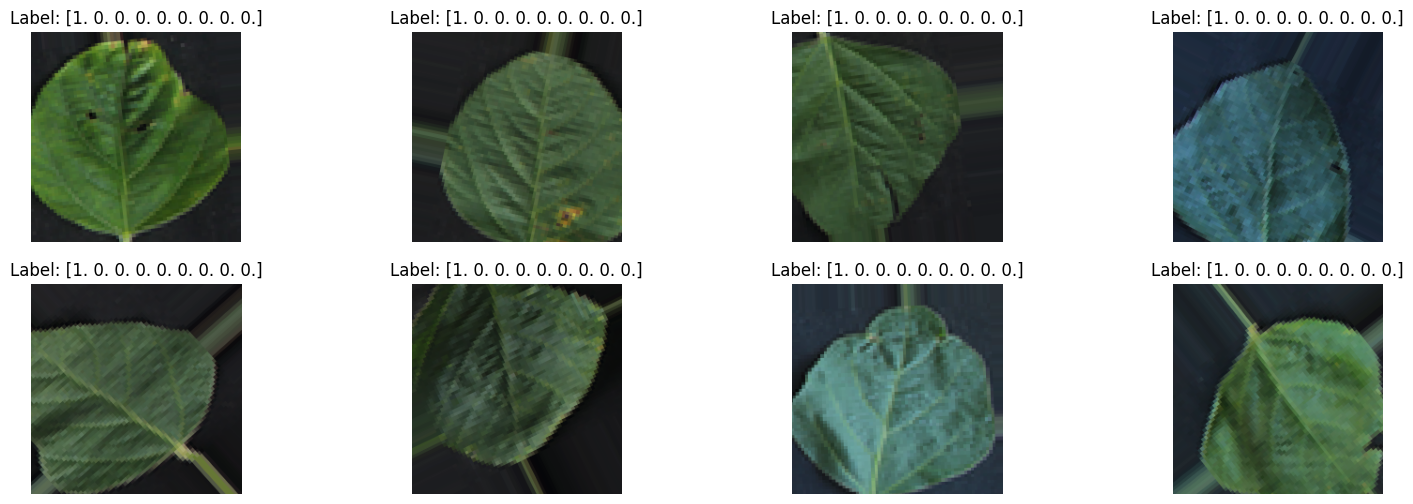

In [ ]:
x_batch, y_batch = next(train_dataset)

fig, axes = plt.subplots(2, 4, figsize=(18, 6))
axes = axes.ravel()

for i in range(8):
    axes[i].imshow(x_batch[i])
    axes[i].set_title(f"Label: {y_batch[i]}")
    axes[i].axis('off')

plt.subplots_adjust(wspace=0.5)
plt.show()


In [ ]:
x_batch[0].shape

(224, 224, 3)

## CNN-SoftMax Model

In [ ]:
cnn_softmax = models.Sequential(name='cnn_softmax')

cnn_softmax.add(layers.Input(shape=(224,224,3)))
cnn_softmax.add(layers.Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform'))
cnn_softmax.add(layers.Conv2D(128, (3,3), padding='same', kernel_initializer='he_uniform'))
cnn_softmax.add(layers.LeakyReLU(0.05))
cnn_softmax.add(layers.MaxPooling2D(2,2, data_format='channels_first'))
cnn_softmax.add(layers.Dropout(0.3))
cnn_softmax.add(layers.Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform', data_format='channels_first'))
cnn_softmax.add(layers.Conv2D(64, (3,3), padding='same', kernel_initializer='he_uniform'))
cnn_softmax.add(layers.LeakyReLU(0.05))
cnn_softmax.add(layers.MaxPooling2D(2,2, data_format='channels_first'))
cnn_softmax.add(layers.Dropout(0.3))
cnn_softmax.add(layers.Flatten(data_format='channels_first'))
cnn_softmax.add(layers.Dense(64, activation='relu'))
cnn_softmax.add(layers.Dropout(0.1))
cnn_softmax.add(layers.Dense(9, activation='softmax'))

In [ ]:
cnn_softmax.summary()

Model: "cnn_softmax"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_96 (Conv2D)          (None, 224, 224, 128)     3584      
                                                                 
 conv2d_97 (Conv2D)          (None, 224, 224, 128)     147584    
                                                                 
 leaky_re_lu_44 (LeakyReLU)  (None, 224, 224, 128)     0         
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 224, 112, 64)     0         
 g2D)                                                            
                                                                 
 dropout_49 (Dropout)        (None, 224, 112, 64)      0         
                                                                 
 conv2d_98 (Conv2D)          (None, 64, 112, 64)       129088    
                                                       

In [ ]:
cnn_softmax.compile(loss='categorical_crossentropy',
                    optimizer=Adamax(learning_rate=0.001),
                    metrics=['accuracy'])

In [ ]:
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy',
                              factor=0.6,
                              patience=2,
                              verbose=1,
                              mode='max',
                              min_lr=1e-7)

early_stop = EarlyStopping(monitor='val_accuracy',
                           patience=3,
                           verbose=1,
                           mode='max')

checkpoint = ModelCheckpoint("cnn_softmax.hdf5",
                             monitor="val_accuracy",
                             mode="max",
                             verbose=1,
                             save_best_only=True,
                             save_freq='epoch')

### Training

In [ ]:
history = cnn_softmax.fit(train_dataset,
                          epochs=30,
                          validation_data=val_dataset,
                          verbose=1,
                          callbacks=[lr_reduce, early_stop, checkpoint])

Epoch 1/30


2023-05-30 20:39:14.944926: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


5919/5919 [==============================] - ETA: 0s - loss: 2.1744 - accuracy: 0.1997

2023-05-30 20:50:05.443242: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_accuracy improved from -inf to 0.20029, saving model to cnn_softmax.hdf5
5919/5919 [==============================] - 730s 123ms/step - loss: 2.1744 - accuracy: 0.1997 - val_loss: 2.1660 - val_accuracy: 0.2003 - lr: 0.0010
Epoch 2/30
5919/5919 [==============================] - ETA: 0s - loss: 1.5066 - accuracy: 0.4580
Epoch 2: val_accuracy improved from 0.20029 to 0.57644, saving model to cnn_softmax.hdf5
5919/5919 [==============================] - 724s 122ms/step - loss: 1.5066 - accuracy: 0.4580 - val_loss: 1.2743 - val_accuracy: 0.5764 - lr: 0.0010
Epoch 3/30
5919/5919 [==============================] - ETA: 0s - loss: 0.8631 - accuracy: 0.6962
Epoch 3: val_accuracy improved from 0.57644 to 0.64041, saving model to cnn_softmax.hdf5
5919/5919 [==============================] - 727s 123ms/step - loss: 0.8631 - accuracy: 0.6962 - val_loss: 1.0269 - val_accuracy: 0.6404 - lr: 0.0010
Epoch 4/30
5919/5919 [==============================] - ETA: 0s - loss: 0.6608 - accuracy

### Results

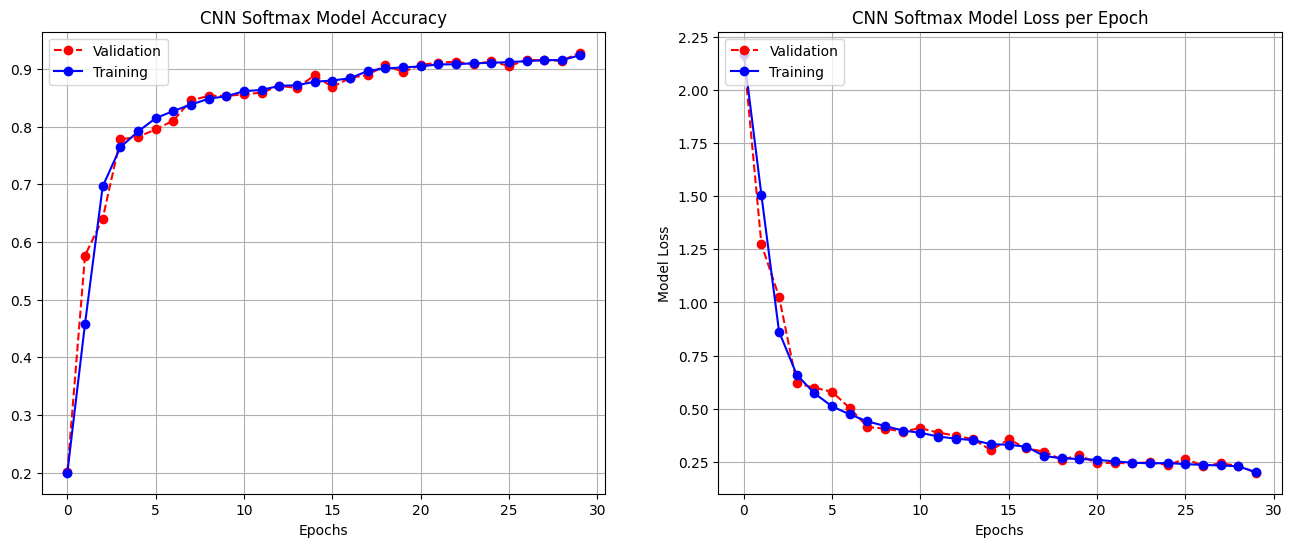

In [ ]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16,6))
ax1.plot(history.history['val_accuracy'], '--or', label="Validation")
ax1.plot(history.history['accuracy'], "-ob", label="Training")
ax1.set_xlabel("Epochs")
ax1.set_label("Model Accuracy")
ax1.legend(loc="upper left")
ax1.set_title("CNN Softmax Model Accuracy")
ax1.grid(True)

ax2.plot(history.history['val_loss'], '--or', label="Validation")
ax2.plot(history.history['loss'], "-ob", label="Training")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Model Loss")
ax2.legend(loc="upper left")
ax2.set_title("CNN Softmax Model Loss per Epoch")
ax2.grid(True)

## CNN-SVM Model

### Load Model

In [ ]:
from keras.models import Sequential, load_model

In [ ]:
model = load_model("./cnn_softmax.hdf5")

In [ ]:
model_acc = model.evaluate(test_dataset)

2023-05-31 04:51:28.682528: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


750/750 [==============================] - 35s 46ms/step - loss: 0.1744 - accuracy: 0.9381


In [ ]:
print(f"Test Data Accuracy: {model_acc[1]*100:.3f}%")
print("Test Data Loss:", model_acc[0])

Test Data Accuracy: 93.809%
Test Data Loss: 0.1744309365749359


### Extract Features

In [ ]:
train_features = model.predict(train_dataset)

   1/5919 [..............................] - ETA: 13:29

2023-05-31 03:50:37.738750: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


5919/5919 [==============================] - 304s 51ms/step


In [ ]:
validation_features = model.predict(val_dataset)

   1/1480 [..............................] - ETA: 2:05

2023-05-31 03:55:53.011375: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1480/1480 [==============================] - 75s 51ms/step


In [ ]:
SVM = SVC(kernel='rbf', gamma=0.1, C = 1, probability=True).fit(train_features, train_dataset.classes)

accuracy_score(SVM.predict(validation_features), val_dataset.classes)

0.9256317079354348

In [ ]:
test_features = model.predict(test_dataset)

  3/750 [..............................] - ETA: 31s

2023-05-31 04:52:03.408352: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


750/750 [==============================] - 32s 42ms/step


In [ ]:
print(f"Hybrid CNN-SVM Accuracy on Test Data: {accuracy_score(SVM.predict(test_features), test_dataset.classes)*100:.3f}%")

Hybrid CNN-SVM Accuracy on Test Data: 93.759%


### Grid Search

In [ ]:
train_features

array([[3.85942876e-01, 1.32803187e-01, 3.11017875e-03, ...,
        3.05190776e-03, 3.31381053e-01, 6.99340925e-02],
       [7.76908576e-01, 6.54628826e-03, 1.29064929e-07, ...,
        2.33731066e-06, 2.15728804e-01, 1.01857651e-04],
       [6.56662941e-01, 3.11673824e-02, 1.59399188e-03, ...,
        2.53186241e-04, 2.76306957e-01, 1.18288975e-02],
       ...,
       [8.05039611e-03, 2.41891530e-06, 7.06952096e-06, ...,
        1.21127663e-09, 5.14445943e-04, 9.90408897e-01],
       [7.25931955e-08, 4.23926014e-16, 6.47860199e-20, ...,
        2.21550568e-26, 2.60239830e-09, 9.99999881e-01],
       [3.03163426e-04, 3.66647919e-06, 6.87624288e-06, ...,
        3.24374773e-02, 8.36364852e-05, 9.45857406e-01]], dtype=float32)

In [ ]:
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}

In [ ]:
grid = GridSearchCV(SVC(),param_grid,verbose=3, n_jobs=-1).fit(train_features, train_dataset.classes)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


In [ ]:
print(grid.best_params_)

{'C': 10, 'gamma': 1, 'kernel': 'rbf'}


In [ ]:
SVM = SVC(kernel='rbf', gamma=1, C = 10, probability=True).fit(train_features, train_dataset.classes)

In [ ]:
accuracy_score(SVM.predict(validation_features), val_dataset.classes)

0.927237386968647

In [ ]:
print(f"Hybrid CNN-SVM Accuracy on Test Data with GridSearch: {accuracy_score(SVM.predict(test_features), test_dataset.classes)*100:.3f}%")

Hybrid CNN-SVM Accuracy on Test Data with GridSearch: 93.759%


### Random Search

In [ ]:
random = RandomizedSearchCV(SVC(),param_grid,verbose=3, n_jobs=-1).fit(train_features, train_dataset.classes)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [ ]:
print(random.best_params_)

{'kernel': 'rbf', 'gamma': 1, 'C': 10}


In [ ]:
SVM = SVC(kernel='rbf', gamma=1, C = 10, probability=True).fit(train_features, train_dataset.classes)

In [ ]:
accuracy_score(SVM.predict(validation_features), val_dataset.classes)

0.927237386968647

In [ ]:
print(f"Hybrid CNN-SVM Accuracy on Test Data with RandomSearch: {accuracy_score(SVM.predict(test_features), test_dataset.classes)*100:.3f}%")

Hybrid CNN-SVM Accuracy on Test Data with RandomSearch: 93.759%


### Pseudocode for CNN-SVM Model

In [ ]:
# Step 1: Train a Convolutional Neural Network (CNN)
cnn_model = train_cnn(X_train, y_train)

# Step 2: Extract features using the trained CNN
X_train_features = extract_features(cnn_model, X_train)

# Step 3: Perform grid and random search to find the best SVM parameters
best_params = perform_parameter_search(X_train_features, y_train)

# Step 4: Train an SVM model using the best parameters and the extracted features
svm_model = train_svm(X_train_features, y_train, best_params)

# Step 5: Make predictions using the trained hybrid model
X_test_features = extract_features(cnn_model, X_test)
y_pred = svm_model.predict(X_test_features)

## Evaluation

In [ ]:
cnn_softmax_predictions = np.argmax(test_features, axis=1)

In [ ]:
cnn_svm_predictions = SVM.predict(test_features)

### Accuracy

In [ ]:
accuracy = pd.DataFrame.from_dict({'cnn_softmax':accuracy_score(cnn_softmax_predictions, test_dataset.classes)*100,
                                   'cnn_svm':accuracy_score(cnn_svm_predictions, test_dataset.classes)*100},
                                   orient='index',
                                   columns=['Accuracy'])
accuracy

,Accuracy
cnn_softmax,93.809444
cnn_svm,93.759386


### ROC

In [ ]:
# Encoder
labels = [0, 1, 2, 3, 4, 5, 6, 7, 8]
lb = LabelBinarizer()
encoder = lb.fit(labels)

#### CNN-Softmax

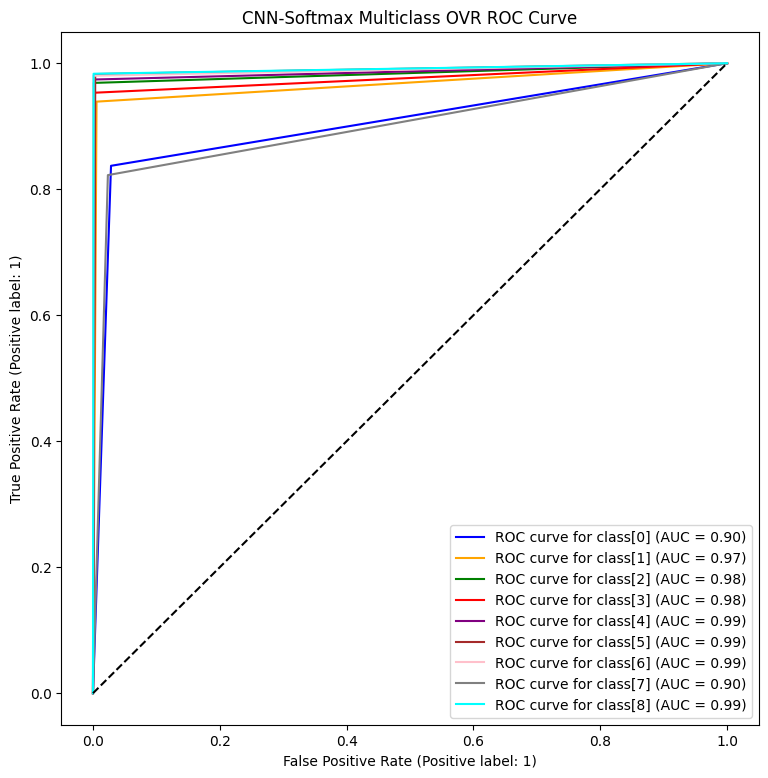

In [ ]:
fig, ax = plt.subplots(figsize=(9, 9))
i=0
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'cyan']
for class_id, color in zip(range(9), colors):
    RocCurveDisplay.from_predictions(
        encoder.transform(test_dataset.classes)[:, class_id],
        encoder.transform(cnn_softmax_predictions)[:, class_id],
        name=f"ROC curve for class[{i}]",
        color=color,
        ax=ax,
    )
    i+=1
plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.title('CNN-Softmax Multiclass OVR ROC Curve')
plt.show();

#### CNN-SVM

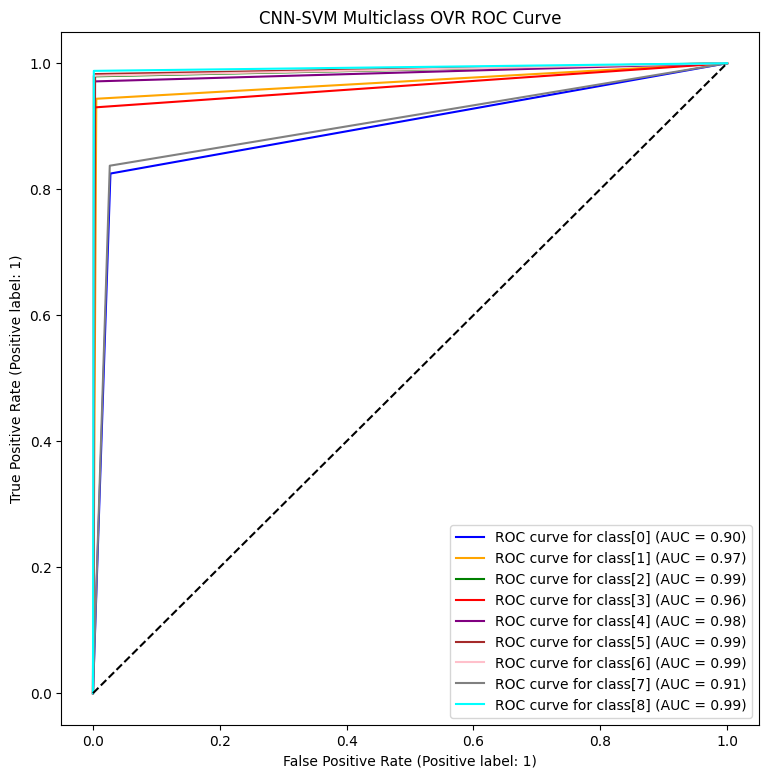

In [ ]:
fig, ax = plt.subplots(figsize=(9, 9))
i=0
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'cyan']
for class_id, color in zip(range(9), colors):
    RocCurveDisplay.from_predictions(
        encoder.transform(test_dataset.classes)[:, class_id],
        encoder.transform(cnn_svm_predictions)[:, class_id],
        name=f"ROC curve for class[{i}]",
        color=color,
        ax=ax,
    )
    i+=1
plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.title('CNN-SVM Multiclass OVR ROC Curve')
plt.show();

### Classification Report

#### CNN-Softmax

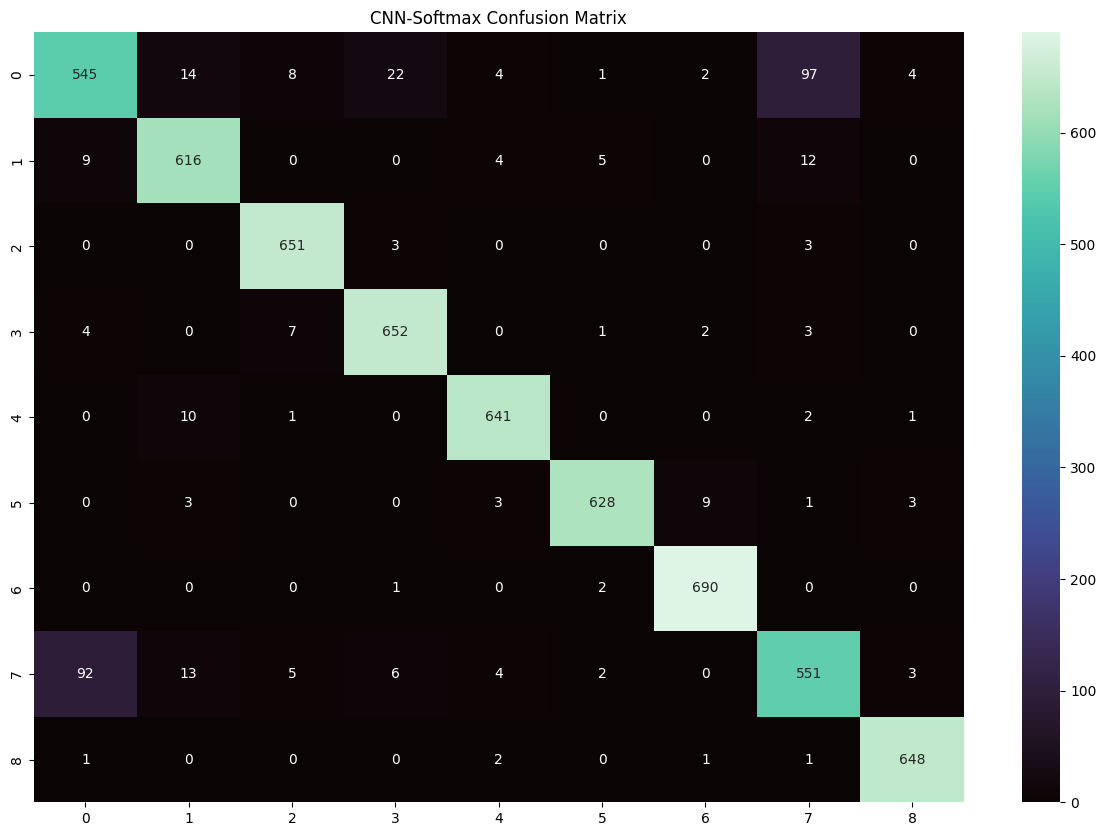

In [ ]:
plt.figure(figsize=(15, 10))
sb.heatmap(confusion_matrix(cnn_softmax_predictions, test_dataset.classes), annot=True, fmt='d', cmap='mako').set_title("CNN-Softmax Confusion Matrix");

In [ ]:
print('-'*15,'Classification Report','-'*15,'\n')
print(classification_report(cnn_softmax_predictions, test_dataset.classes))

--------------- Classification Report --------------- 

              precision    recall  f1-score   support

           0       0.84      0.78      0.81       697
           1       0.94      0.95      0.95       646
           2       0.97      0.99      0.98       657
           3       0.95      0.97      0.96       669
           4       0.97      0.98      0.98       655
           5       0.98      0.97      0.98       647
           6       0.98      1.00      0.99       693
           7       0.82      0.82      0.82       676
           8       0.98      0.99      0.99       653

    accuracy                           0.94      5993
   macro avg       0.94      0.94      0.94      5993
weighted avg       0.94      0.94      0.94      5993



#### CNN-SVM

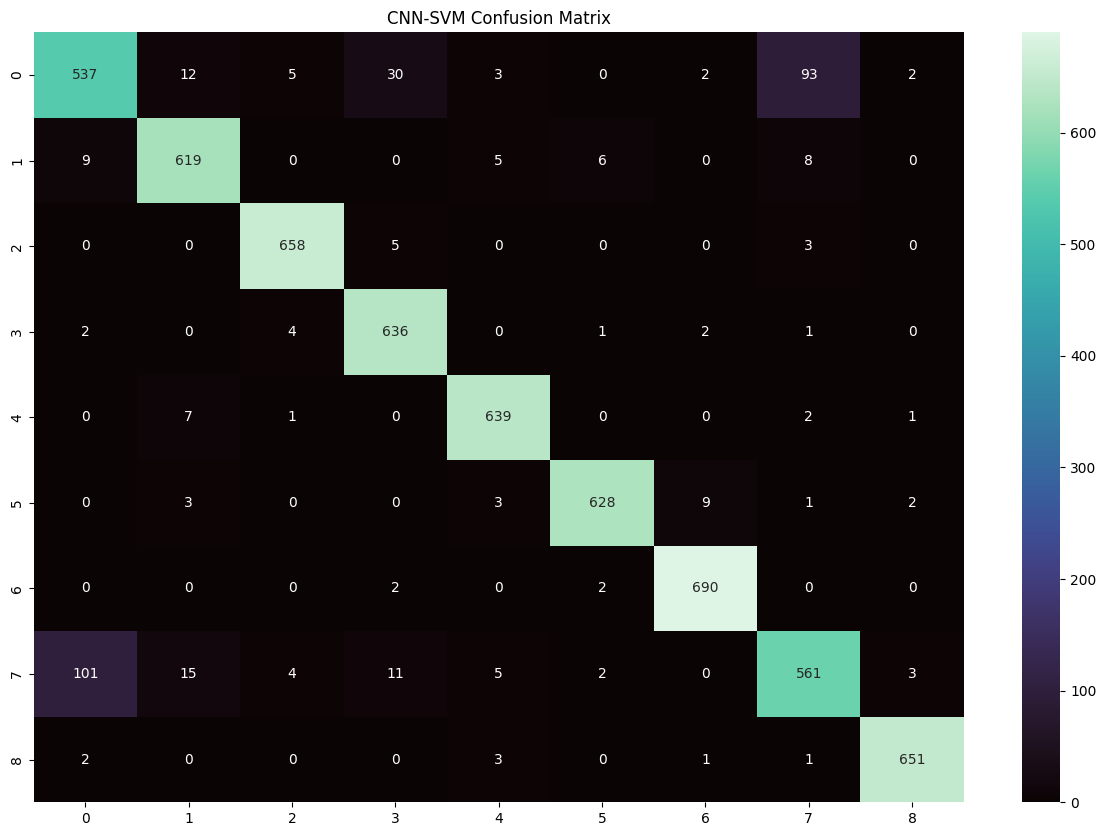

In [ ]:
plt.figure(figsize=(15, 10))
sb.heatmap(confusion_matrix(cnn_svm_predictions, test_dataset.classes), annot=True, fmt='d', cmap='mako').set_title("CNN-SVM Confusion Matrix");

In [ ]:
print('-'*15,'Classification Report','-'*15,'\n')
print(classification_report(cnn_svm_predictions, test_dataset.classes))

--------------- Classification Report --------------- 

              precision    recall  f1-score   support

           0       0.82      0.79      0.80       684
           1       0.94      0.96      0.95       647
           2       0.98      0.99      0.98       666
           3       0.93      0.98      0.96       646
           4       0.97      0.98      0.98       650
           5       0.98      0.97      0.98       646
           6       0.98      0.99      0.99       694
           7       0.84      0.80      0.82       702
           8       0.99      0.99      0.99       658

    accuracy                           0.94      5993
   macro avg       0.94      0.94      0.94      5993
weighted avg       0.94      0.94      0.94      5993



## Conclusion


The softmax model achieves an accuracy of 94% on the test set. Looking at the precision, recall, and F1-scores, we can see that it performs well across most classes. Notably, classes 2, 4, 5, 6, and 8 have particularly high scores, indicating that the model is effective in correctly identifying instances belonging to these classes. These classes have F1-scores ranging from 0.98 to 0.99, indicating a high level of accuracy. On the other hand, class 0 has a lower F1-score of 0.81, indicating that the model struggles slightly with this class. Class 7 also has a relatively lower F1-score of 0.82. These lower scores suggest that the model may have difficulty distinguishing instances in these classes.

The SVM model achieves the same overall accuracy of 94% on the test set as the softmax model. Similar to the softmax model, the SVM model demonstrates high precision, recall, and F1-scores for most classes. Notably, classes 2, 4, 5, and 6 have F1-scores of 0.98 or higher, indicating excellent performance. However, there are slight differences in performance between the SVM and softmax models for certain classes. The SVM model outperforms the softmax model for class 0 and class 7, with F1-scores of 0.80 and 0.82, respectively. This suggests that the SVM model may have an advantage in correctly classifying instances belonging to these classes compared to the softmax model.

In summary, both the softmax and SVM models achieve similar overall accuracy and demonstrate high performance on most classes. However, there are slight differences in performance for specific classes between the two models.